In [1]:
#import libraries
import pandas as pd
import numpy as np
import datetime

from sklearn.preprocessing import StandardScaler

from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols

import seaborn as sns
import matplotlib.pyplot as plt

import copy 

import warnings
warnings.filterwarnings('ignore')

##### I will use the ordinal dataframe to make a heat map just to get an idea of potential EDA

In [2]:
#oridinal dataframe
df = pd.read_csv('Data/Crime_data/Other/pre_c_crime_2.csv')
df = df.drop('New Georeferenced Column', axis = 1)
df.head()

,ARREST_DATE,Crime Severity,ARREST_BORO,ARREST_PRECINCT,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude
0,2019-03-01,1,2,14,1,1,2,40.757578,-73.989545
1,2019-03-01,0,3,109,0,1,4,40.781417,-73.778168
2,2019-03-01,0,1,60,0,1,2,40.575574,-73.981204
3,2019-03-01,1,1,79,0,1,2,40.688378,-73.944912
4,2019-03-01,0,0,41,2,1,5,40.814684,-73.891918


In [3]:
#I will also upload the dataframe without ordinals for some plots
data = pd.read_csv('Data/EDA_data/crime_master.csv')
data.head()

,ARREST_DATE,Crime Severity,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column
0,2019-03-01,Mild,Queens,25-44,M,BLACK,40.770267,-73.915857,POINT (-73.91585715599996 40.770267001000036)
1,2019-03-01,Mild,Bronx,25-44,M,BLACK,40.836266,-73.911329,POINT (-73.91132866299995 40.83626606400003)
2,2019-03-01,Mild,Manhatten,45-64,M,WHITE HISPANIC,40.768899,-73.982095,POINT (-73.98209493899998 40.76889926000007)
3,2019-03-01,Minor,Manhatten,25-44,M,BLACK HISPANIC,40.798601,-73.933519,POINT (-73.93351914299996 40.79860146500005)
4,2019-03-01,Mild,Manhatten,25-44,M,WHITE HISPANIC,40.797872,-73.944117,POINT (-73.94411676299995 40.797871503000074)


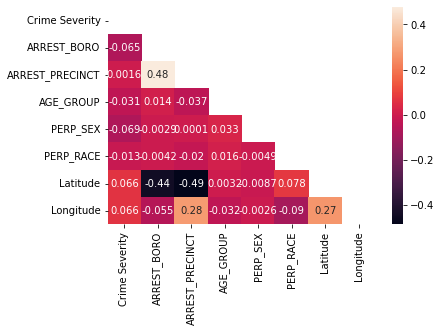

In [4]:
#Let us see a quick heat correlation map
scaler = StandardScaler()
df2 = copy.deepcopy(df[['Crime Severity', 'ARREST_BORO', 'ARREST_PRECINCT',
                        'AGE_GROUP','PERP_SEX', 'PERP_RACE', 'Latitude', 'Longitude']])
scaler.fit(df2)
matrix_corr = df2.corr()
mask = np.triu(np.ones_like(matrix_corr, dtype=bool))
sns.heatmap(matrix_corr, annot=True, mask = mask)
plt.show()

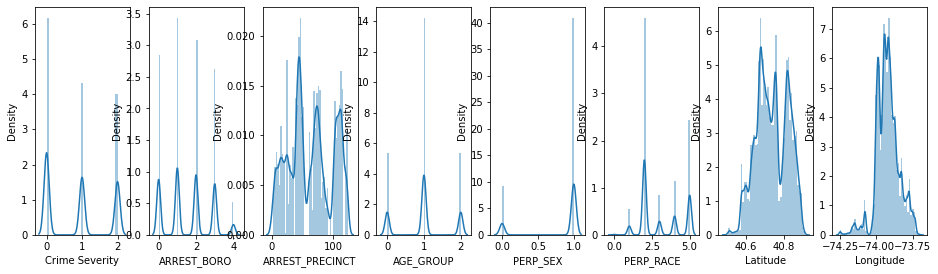

In [5]:
#Check distribution skewness
l = df2.columns.values
number_of_columns=8
number_of_rows = len(l)-1/number_of_columns

plt.figure(figsize=(2*number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True) 

### Specificailly looking at dates

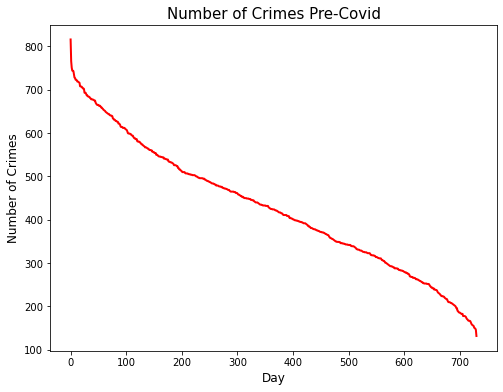

In [6]:
#Bar plot of number of offenses each Day
plt.figure(figsize=[8,6])
plt.plot(data['ARREST_DATE'].value_counts().values, color = 'red', lw = 2)
plt.xlabel('Day', size = 12)
plt.ylabel('Number of Crimes', size = 12)
plt.title('Number of Crimes Pre-Covid', size= 15)
plt.show()

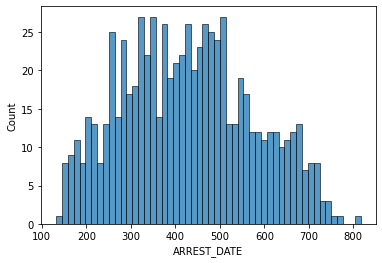

In [7]:
#A histogram showing the distribution of number of crimes over date, 52 bins=52weeks
sns.histplot(data=df, x = data['ARREST_DATE'].value_counts(), bins=52)

There seems to be more crime after 10 weeks before it starts dropping again, something must be happening suring the days and months so will look into that

In [8]:
#add weekday and month to this table
df['ARREST_DATE'] = pd.to_datetime(df['ARREST_DATE']) #convert column
df['Month'] = df['ARREST_DATE'].dt.month
df['WeekDay'] = df['ARREST_DATE'].dt.weekday

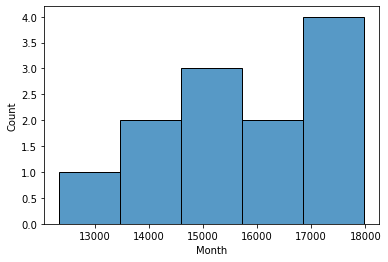

In [9]:
#A histogram showing the distribution of number of crimes over month
sns.histplot(data=df, x = df['Month'].value_counts())

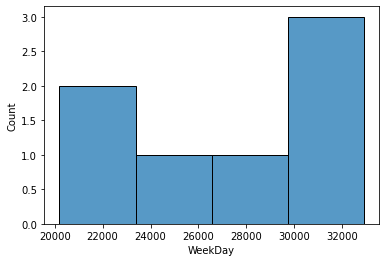

In [10]:
#A histogram showing the distribution of number of crimes over weekday
sns.histplot(data=df, x = df['WeekDay'].value_counts())

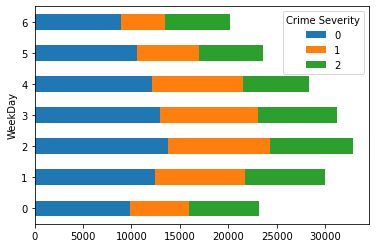

In [11]:
#Bar plot showing proportion of crimes committed per age group for crime severity
pd.crosstab(df['WeekDay'],df['Crime Severity']).plot(kind="barh",stacked=True)

In [12]:
#Trying some stats, first choose 2 categories
two_way_table = pd.crosstab(index=df["WeekDay"], columns=df["Crime Severity"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 1346.0229606695657
p-value : 6.011635557516533e-281
degrees of freedom : 12
expected counts : 
 [[ 9861.15661779  6914.42423986  6393.41914235]
 [12748.55298772  8939.00251442  8265.44449786]
 [14003.2765282   9818.78682359  9078.93664821]
 [13263.9770744   9300.40644875  8599.61647685]
 [12070.11698925  8463.29824413  7825.58476662]
 [10030.97842669  7033.49952458  6503.52204872]
 [ 8594.94137596  6026.58220466  5572.47641938]]


Crime Severity,0,1,2
WeekDay,,,
0,-0.158240,-12.374803,12.842765
1,-3.955548,5.188734,-0.936143
2,-3.168300,9.984153,-6.715887
3,-3.772719,10.857434,-6.941264
4,0.076627,13.901516,-14.315342
5,7.645679,-9.912085,1.689479
6,5.000205,-23.765721,18.797326


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the day of the week, meaning there is a distribution of crime.

1. Monday (0) Overall less crimes happens on Monday, and crimes significnatly more likely to be severe
2. Tuesday (1) crimes are significantly more likely to be mild
3. Wednesday (2) the crimes are again significantly more likely to be mild
4. Thursday (3) the crimes are  significantly more likely to be mild
5. Friday (4) crimes most likely to happen are minor and mild, signifcantly more mild
6. Saturday (5) crimes most likely to happen are minor or severe, significantly more minor
7. Sunday (6) crimes most likely to happen are minor or severe, significantly more severe

Overall:
    
    Monday, Saturday and Sunday is when the severe crimes significantly occur.
    Tuesday to Friday is when mild crimes significantly occur compared to severe crimes.
    Friday to Sunday is when minor crimes signifcantly occur than mild crimes
    
Therefore, we could interpret possible patterns. Such as people are more likely to let loose are weekends or interact with others more that might lead to more severe crime.

In [13]:
#perform one-way ANOVA - all our values are categorical, we would need quantitative variable for 2-way ANOVA
f_oneway(df['WeekDay'], df['Crime Severity'], df['ARREST_BORO'])

F_onewayResult(statistic=106386.20232241348, pvalue=0.0)

This shows that there is a significant relationship between the day of the week, crime severity and the borough

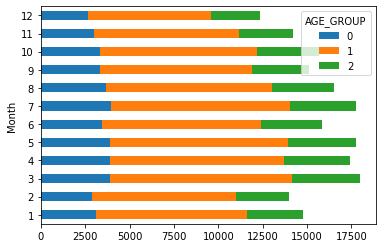

In [14]:
#Bar plot showing proportion of crimes committed per age group for crime severity
pd.crosstab(df['Month'],df['AGE_GROUP']).plot(kind="barh",stacked=True)

In [15]:
#Lets do the same stats but with Month
two_way_table = pd.crosstab(index=df["Month"], columns=df["Crime Severity"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 333.2846310808533
p-value : 2.055669926648505e-57
degrees of freedom : 22
expected counts : 
 [[6294.47301223 4413.54482642 4080.98216135]
 [5941.6352188  4166.14279375 3852.22198745]
 [7648.79129778 5363.16276121 4959.04594101]
 [7422.36221924 5204.39571492 4812.24206584]
 [7559.83701692 5300.78999303 4901.37299005]
 [6733.28575654 4721.23058719 4365.48365626]
 [7556.00644981 5298.10408435 4898.88946584]
 [7023.55762039 4924.76277812 4553.6796015 ]
 [6426.41476853 4506.05945866 4166.52577281]
 [6668.59173411 4675.86857396 4323.53969193]
 [6045.48614956 4238.96076236 3919.55308809]
 [5252.5587561  3682.97766603 3405.46357787]]


Crime Severity,0,1,2
Month,,,
1,-6.365151,6.035379,0.862542
2,0.593430,-0.771508,0.133351
3,6.838326,4.264122,-11.929245
4,2.983876,1.729993,-5.071546
5,2.330103,-1.546741,-0.994080
6,2.128440,-5.104469,2.870932
7,-0.031994,-2.638002,2.735836
8,-4.392557,4.544878,0.206348
9,-1.379750,-2.782146,4.374208


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the Month of the year, meaning there is a distribution of crime.

1. Jan - There are significantly more mild and severe crimes, and we see signifcantly more mild
2. Feb - Although less significant than Jan there are more minor and severe crimes
3. March - Significantly more than Feb and crimes more likely to be minor or mild
4. April - Significantly, crimes more likely to be minor or mild
5. May - Crimes are more significantly to be Minor
6. June - Significantly, crimes more likely to be minor or severe, more so severe
7. July - Crimes are significantly more likely to be severe
8. Aug - Significantly more likely to be mild or severe, significantly more mild
9. Sept - Crimes are significantly more likely to be severe
10. Oct - Signifantly more likely to be mild or severe, not by much
11. Nov - Signifantly more likely to be mild or severe, not by much
12. Dec - Crimes are significantly more likely to be severe

Common trends we can see:

    The highest amount of severe crimes are committed in September and December, followed by June, July & November.
    The highest amount of mild crimes are committed in January, March and August.
    The minor crimes seem to be more likely to significantly occur from Feb to June

In [16]:
#perform one-way ANOVA 
f_oneway(df['Month'], df['Crime Severity'], df['ARREST_BORO'])

F_onewayResult(statistic=389187.6411643349, pvalue=0.0)

Again we see that these values are significant!

### Relations with Borough

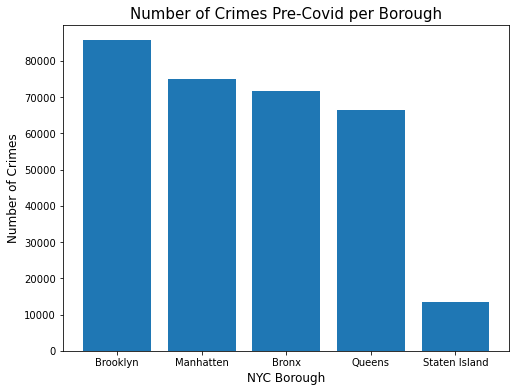

In [17]:
#Bar plot of number of offenses in each borrow
plt.figure(figsize=[8,6])
plt.bar(data['ARREST_BORO'].value_counts().index.tolist(), 
        data['ARREST_BORO'].value_counts().values)
plt.xlabel('NYC Borough', size = 12)
plt.ylabel('Number of Crimes', size = 12)
plt.title('Number of Crimes Pre-Covid per Borough', size= 15)
plt.show()

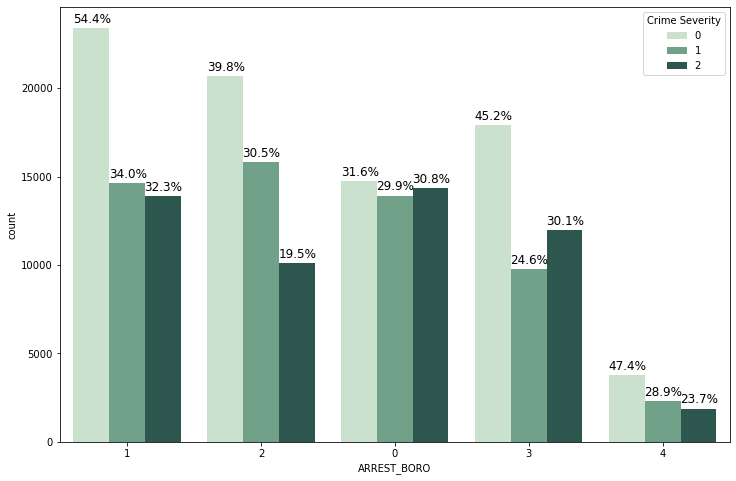

In [18]:
#Calculating the percentage of crime severity at each borough
boro_name = ['Manhatten', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
crime_level = ['Minor', 'Mild', 'Severe']
subtotal_boro = df.groupby('ARREST_BORO')['Crime Severity'].agg('count').sort_values(ascending=False) #total of each boro count
fig = plt.figure(figsize=[12,8])
ax = sns.countplot(x="ARREST_BORO", hue="Crime Severity", 
                   data=df[['ARREST_BORO', 'Crime Severity']], 
                   order = subtotal_boro.index,
                  palette = "ch:2.5,-.2,dark=.3")

boro_num2 = [val for val in range(0, 5)]*3 #[0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,] work for the order
for p, i in zip(ax.patches, boro_num2):
    percent = p.get_height()/subtotal_boro[i]
    ax.annotate('{:.1f}%'. format(percent*100), (p.get_x()+0.138, p.get_height()+300), ha='center', size=12)

In [19]:
#Lets look at this more closey
two_way_table = pd.crosstab(index=df["ARREST_BORO"], columns=df["Crime Severity"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 2936.5211484101974
p-value : 0.0
degrees of freedom : 8
expected counts : 
 [[18326.2843303  12849.98398377 11881.73168593]
 [22117.69454011 15508.43670632 14339.86875357]
 [19851.70128045 13919.57250618 12870.72621337]
 [16879.60681535 11835.60580641 10943.78737824]
 [ 3397.71303379  2382.40099732  2202.8859689 ]]


Crime Severity,0,1,2
ARREST_BORO,,,
0,-39.558231,12.917435,30.533968
1,13.596428,-9.695897,-5.114223
2,8.913787,22.339297,-32.728043
3,11.975410,-25.433907,12.789406
4,8.957668,-1.809500,-8.056155


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the NYC Borough, meaning there is a distribution of crime.

1. Bronx (0) - Crimes are more likely to be mild or severe, sig more severe
2. Brooklyn (1) - Crimes are significantly more likely to be minor
3. Manhatten (2) - Crimes are significantly more likely to be minor or mild, sig more mild
4. Queens (3) - Crimes are significantly more likely to be minor or severe
5. Staten Island (4) - Crimes are more significantly to be minor

Common trends we can see:

    Crime are signifcantly more likely to be minor (except in the Bronx). With mild crimes significantly more likely to occur in the Bronc and Manhatten. While severe crime is significantly more likly to occur in the Bronx and Queens

In [20]:
#perform one-way ANOVA 
f_oneway(df['ARREST_BORO'], df['Crime Severity'], df['ARREST_PRECINCT'])

F_onewayResult(statistic=590116.0572474473, pvalue=0.0)

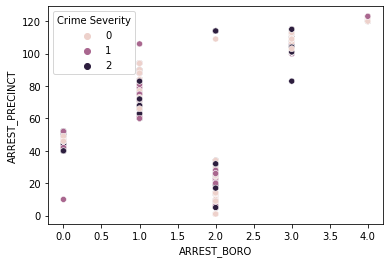

In [21]:
#plot showing crime severoty when arrest precinct and boro are plotted together
sns.scatterplot(data=df, x=df.ARREST_BORO, y=df.ARREST_PRECINCT, hue =df['Crime Severity'])

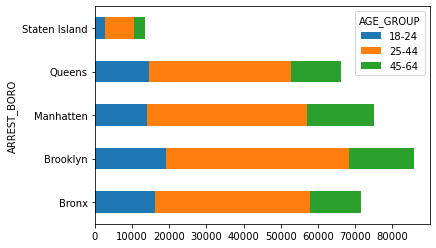

In [22]:
#Bar plot showing proportion of crimes committed per age group at each boro
pd.crosstab(data['ARREST_BORO'], data['AGE_GROUP']).plot(kind="barh",stacked=True)

In [23]:
#Lets do the same stats but with ARREST BORO and age group
two_way_table = pd.crosstab(index=df["ARREST_BORO"], columns=df["AGE_GROUP"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 526.5453914260033
p-value : 1.413010378760466e-108
degrees of freedom : 8
expected counts : 
 [[ 9304.2745473  24501.08192998  9252.64352272]
 [11229.17764701 29569.95734993 11166.86500306]
 [10078.73039702 26540.46781964 10022.80178334]
 [ 8569.79479473 22566.96568027  8522.23952501]
 [ 1725.02261394  4542.52722019  1715.45016587]]


AGE_GROUP,0,1,2
ARREST_BORO,,,
0,5.684731,1.084128,-7.003290
1,6.292011,-0.311555,-5.929096
2,-16.947499,-1.771434,19.117457
3,5.848536,-0.090846,-5.750822
4,-1.334351,2.412593,-1.571687


The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the Month of the year, meaning there is a distribution of crime.

1. Bronx (0) - Crimes are more likely to occur in the 18-24 and the 25-44 age groups, sig more in 18-24
2. Brooklyn (1) - Crimes are significantly more likely to be committed byt the 18-24 age group
3. Manhatten (2) - Crimes are significantly more likely to be committed by the 45 to 64 age group
4. Queens (3) - Crimes are significantly more likely to be committed by the 18-24 age group
5. Staten Island (4) - Crimes are more significantly to be committed by the 24-44 age group

Common trends we can see:

    The 18-24 age group are more likely to commit crimes in 3/5 boroughs. While the 45 to 64 age group are more likely to do crime in Manhatten.  And the 25-44 more likely to commit crime in the Bronx and Staten Island

In [24]:
#perform one-way ANOVA 
f_oneway(df['ARREST_BORO'], df['AGE_GROUP'], df['PERP_RACE'])

F_onewayResult(statistic=169905.29221649547, pvalue=0.0)

Yes we have signifcance in the boroughs with our demographics

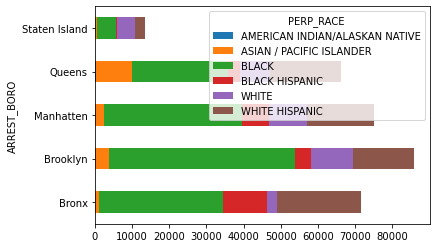

In [25]:
#Bar plot showing proportion of crimes committed per rae at each boro
pd.crosstab(data['ARREST_BORO'], data['PERP_RACE']).plot(kind="barh",stacked=True)

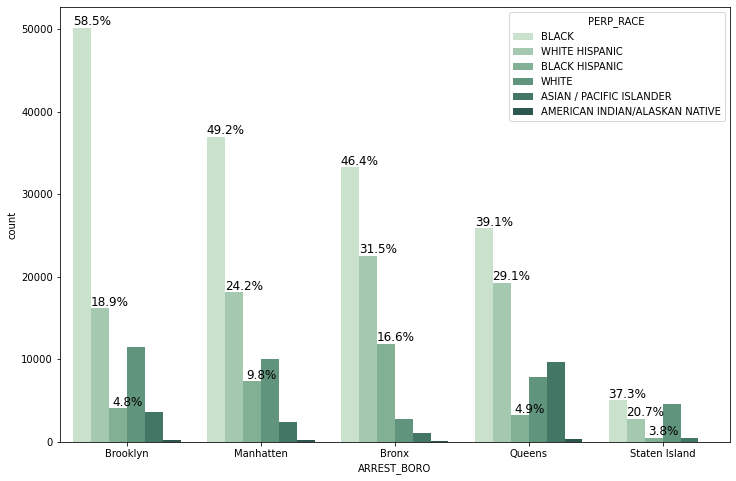

In [26]:
#Calculating the percentage of crime severity at each borough
boro_name = ['Manhatten', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island']
race = ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 
        'BLACK', 'BLACK HISPANIC', 'WHITE','WHITE HISPANIC']
subtotal_boro = data.groupby('ARREST_BORO')['PERP_RACE'].agg('count').sort_values(ascending=False) #total of each boro count
fig = plt.figure(figsize=[12,8])
ax = sns.countplot(x="ARREST_BORO", hue="PERP_RACE", 
                   data=data[['ARREST_BORO', 'PERP_RACE']], 
                   order = subtotal_boro.index,
                  palette = "ch:2.5,-.2,dark=.3")

boro_num2 = [val for val in range(0, 5)]*3 #[0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,] work for the order
for p, i in zip(ax.patches, boro_num2):
    percent = p.get_height()/subtotal_boro[i]
    ax.annotate('{:.1f}%'. format(percent*100), (p.get_x()+0.138, p.get_height()+300), ha='center', size=12)

In [27]:
#Lets do the same stats but with ARREST BORO and age group
two_way_table = pd.crosstab(index=df["ARREST_BORO"], columns=df["PERP_RACE"])

#Calculate the chi-square test
result_chi = stats.chi2_contingency(observed = two_way_table)
chi2, p, dof, expected = stats.chi2_contingency(observed = two_way_table)

print('chi-square statistic :', result_chi[0])
print('p-value :', result_chi[1])
print('degrees of freedom :', result_chi[2])
print('expected counts : \n', result_chi[3])

table = sm.stats.Table(two_way_table)
table.standardized_resids

chi-square statistic : 23025.560807982594
p-value : 0.0
degrees of freedom : 20
expected counts : 
 [[1.19410960e+02 2.42028957e+03 2.06351237e+04 3.75223353e+03
  5.16901614e+03 1.09619261e+04]
 [1.44115146e+02 2.92100812e+03 2.49041952e+04 4.52850964e+03
  6.23840153e+03 1.32297704e+04]
 [1.29350318e+02 2.62174616e+03 2.23527205e+04 4.06455656e+03
  5.59926729e+03 1.18743592e+04]
 [1.09984655e+02 2.22923183e+03 1.90061863e+04 3.45603209e+03
  4.76097383e+03 1.00965913e+04]
 [2.21389218e+01 4.48724317e+02 3.82577436e+03 6.95668176e+02
  9.58341211e+02 2.03235302e+03]]


PERP_RACE,0,1,2,3,4,5
ARREST_BORO,,,,,,
0,-4.734544,-43.545938,-12.041202,66.012810,-57.997725,37.935689
1,-4.222415,-16.681008,57.235041,-36.748694,10.990684,-40.713815
2,-1.556901,-21.484260,1.369612,8.650752,16.176638,-7.693573
3,10.311580,89.739954,-40.927222,-29.356276,-0.555603,17.663167
4,1.709474,-7.781522,-22.039500,-15.191483,63.005555,-7.989777


American Indian/Alaskan Native = 0
ASIAN / PACIFIC ISLANDER = 1
BLACK = 2
BLACK HISPANIC = 3
WHITE = 4
WHITE HISPANIC = 5

The Chi-Square test above shows that there is a significant relationship on the dependency between crime severity and the Month of the year, meaning there is a distribution of crime.

1. Bronx (0) - Crimes are more likely to be committed by Black Hispanic and White Hispanics
2. Brooklyn (1) - Crimes are significantly more likely to be committed by Black and White, sig more Black
3. Manhatten (2) - Crimes are significantly more likely to be committed by Black, Black Hispanic & White, Sig more white
4. Queens (3) - Crimes are significantly more likely to be committed by Indigenious and Asian, sig more Asian
5. Staten Island (4) - Crimes are more significantly to be committed by Indigenious and whites, sig more whites

Common trends we can see:

    Trends may be tied more to economics. Queens and Staten are more expensive, so more likely to occur by Asian & Whites.

#### Relations with Crime Severity

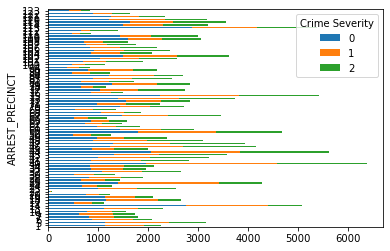

In [28]:
#Bar plot showing proportion of crimes committed per age group at each precinct
pd.crosstab(df['ARREST_PRECINCT'], df['Crime Severity']).plot(kind="barh",stacked=True)

maybe sometime here so I am going to look at each borough more closely

In [29]:
#Seperate data into boroughs
Bronx = df.loc[df['ARREST_BORO'] == 0]
Brooklyn = df.loc[df['ARREST_BORO'] == 1]
Manhatten = df.loc[df['ARREST_BORO'] == 2]
Queens = df.loc[df['ARREST_BORO'] == 3]
Staten = df.loc[df['ARREST_BORO'] == 4]

Now do each precinct in each borough

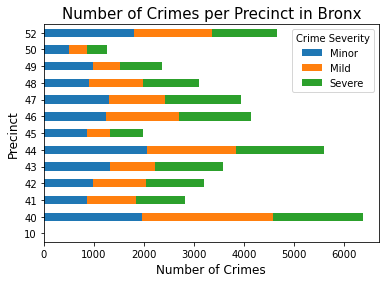

In [30]:
#plot Precints in Bronx with crime severity
pd.crosstab(Bronx['ARREST_PRECINCT'], 
            Bronx['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct in Bronx', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [31]:
#perform one-way ANOVA 
f_oneway(Bronx['ARREST_PRECINCT'], Bronx['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=5731345.993682817, pvalue=0.0)

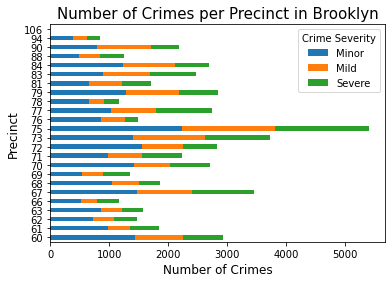

In [32]:
#plot Precints in Brooklyn with crime severity
pd.crosstab(Brooklyn['ARREST_PRECINCT'], 
            Brooklyn['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct in Brooklyn', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [33]:
#perform one-way ANOVA 
f_oneway(Brooklyn['ARREST_PRECINCT'], Brooklyn['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=4032569.478927156, pvalue=0.0)

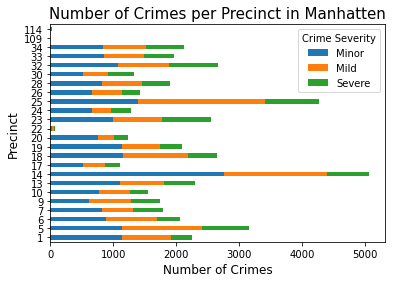

In [34]:
#plot Precints in Manhatten with crime severity
pd.crosstab(Manhatten['ARREST_PRECINCT'], 
            Manhatten['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct in Manhatten', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [35]:
#perform one-way ANOVA 
f_oneway(Manhatten['ARREST_PRECINCT'], Manhatten['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=146247.2701721074, pvalue=0.0)

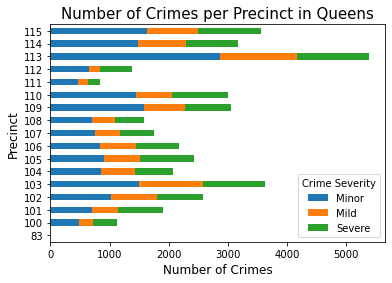

In [36]:
#plot Precints in Queens with crime severity
pd.crosstab(Queens['ARREST_PRECINCT'], 
            Queens['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct in Queens', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [37]:
#perform one-way ANOVA 
f_oneway(Queens['ARREST_PRECINCT'], Queens['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=19950318.090575423, pvalue=0.0)

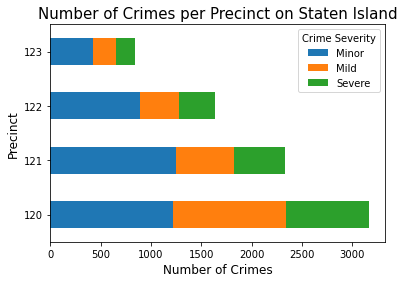

In [38]:
#plot Precints on Staten Island with crime severity
pd.crosstab(Staten['ARREST_PRECINCT'], 
            Staten['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Precinct', size = 12)
plt.title('Number of Crimes per Precinct on Staten Island', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [39]:
#perform one-way ANOVA 
f_oneway(Staten['ARREST_PRECINCT'], Staten['Crime Severity']) #significant difference between precincts with crime severity

F_onewayResult(statistic=68842857.73942314, pvalue=0.0)

In all boroughs, there is a significant difference with the number of crimes per precinct and crime severity

### Relations with demographic factors

We aren't focusing too much on demographics for this assignment, so I will just do some basic one-way ANOVAS

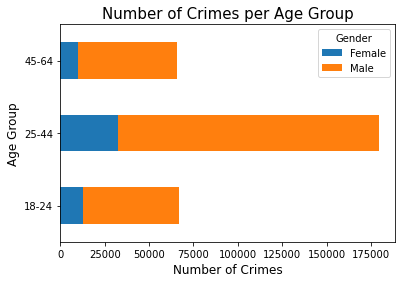

In [40]:
#plot gender by Age group
pd.crosstab(data['AGE_GROUP'], 
            data['PERP_SEX']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Age Group', size = 12)
plt.title('Number of Crimes per Age Group', size= 15)
plt.legend(['Female','Male'], title = 'Gender')
plt.show()

In [41]:
#perform one-way ANOVA 
f_oneway(df['AGE_GROUP'], df['PERP_SEX']) #significant difference between age and sex

F_onewayResult(statistic=10775.15228867766, pvalue=0.0)

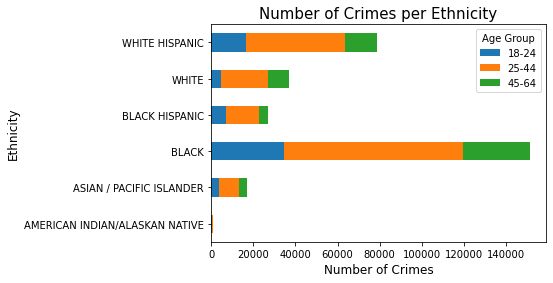

In [42]:
#plot ethnicity by sex
pd.crosstab(data['PERP_RACE'], 
            data['AGE_GROUP']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Ethnicity', size = 12)
plt.title('Number of Crimes per Ethnicity', size= 15)
plt.legend(['18-24','25-44','45-64'], title = 'Age Group')
plt.show()

In [43]:
#perform one-way ANOVA 
f_oneway(df['AGE_GROUP'], df['PERP_RACE']) #significant difference between age and race

F_onewayResult(statistic=339689.02217587846, pvalue=0.0)

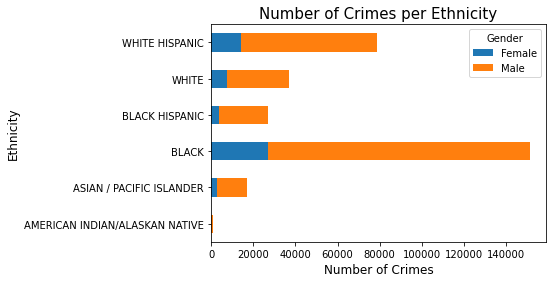

In [44]:
#plot ethnicity by sex
pd.crosstab(data['PERP_RACE'], 
            data['PERP_SEX']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Ethnicity', size = 12)
plt.title('Number of Crimes per Ethnicity', size= 15)
plt.legend(['Female','Male'], title = 'Gender')
plt.show()

In [45]:
#perform one-way ANOVA 
f_oneway(df['PERP_RACE'], df['PERP_SEX']) #significant difference between race and sex

F_onewayResult(statistic=459529.2958497528, pvalue=0.0)

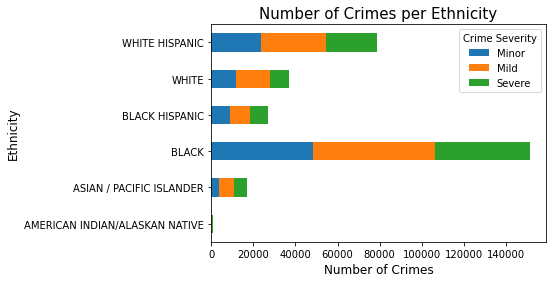

In [46]:
#plot ethnicity by crime severity
pd.crosstab(data['PERP_RACE'], 
            data['Crime Severity']).plot(kind="barh",stacked=True)
plt.xlabel('Number of Crimes', size = 12)
plt.ylabel('Ethnicity', size = 12)
plt.title('Number of Crimes per Ethnicity', size= 15)
plt.legend(['Minor','Mild','Severe'], title = 'Crime Severity')
plt.show()

In [47]:
#perform one-way ANOVA 
f_oneway(df['PERP_RACE'], df['Crime Severity']) #significant difference between race and crime severity

F_onewayResult(statistic=353046.18824348395, pvalue=0.0)

## MISC

Just trying

Try plotting latitude/longitude
    
    Maybe by borough
    Try by crime severity

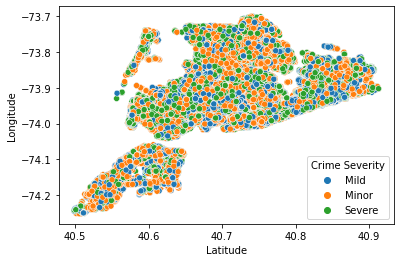

In [48]:
#let us try labeling
sns.scatterplot(data=data, x=data.Latitude, y=data.Longitude, hue =data['Crime Severity'])